# text2poem

### Aim
Given a textual description, generate a poem from it. 

### To-Do
- [ ] Clean up the variable names, etc
- [ ] Understand the T5 architecture and freeze the base layers if needed
- [ ] Create the $(\text{summary}, \ \text{poem})$ dataset using sites like [Poem Analysis](https://poemanalysis.com/). Ideally, smaller poems would be preffered. Might need to create manually, as scraping is not only difficult, but also lead to bad data. Stanza-by-Stanza is too detailed, and some summaries barely contain any information about the poem. Thus, data samples may need to be manually checked. Need to select famous poems that have good quality summaries available.
    - Doesn't work properly when tested with training set of $9$ poems, will need to try with more data
    - Another alternative, $(\text{topic}, \ \text{poem})$ dataset. Given a set of keywords, generate a poem. Dataset creation would be simple using LDA topic modelling etc.
        - [Topic Idenitification NLP 1](https://www.pluralsight.com/guides/topic-identification-nlp)
        - [Topic Idenitification NLP 2](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925)
        - [Example](https://monkeylearn.com/keyword-extractor-online/)
- [ ] Clean the dataset, remove very long poems, if possible select by prominent authors, remove poems with no rhyming scheme.
- [ ] Change the RAKE algorithm
- [ ] Check whether tokenizer preserves "\n" else replace by some other token
- [ ] Calculate lengths of poems after data cleaning
### Ideas
- [ ] Rhyming scheme as T5 prefix

### References
- [Base code for this notebook](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb) (This had quite a few bugs) 
- [T5 finetuning tips](https://discuss.huggingface.co/t/t5-finetuning-tips/684/2)
- [T5 Docs](https://huggingface.co/transformers/model_doc/t5.html)
- [Training T5](https://huggingface.co/transformers/model_doc/t5.html#training) (Not detailed enough)
- [Finetuning T5](https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb) (Probably the most extensive tutorial)
- [Few Shot Learning with T5](https://towardsdatascience.com/poor-mans-gpt-3-few-shot-text-generation-with-t5-transformer-51f1b01f843e)
- [Some Famous Poetry](https://medium.com/@EmEmbarty/31-of-the-best-and-most-famous-short-classic-poems-of-all-time-e445986e6df)
- [Poetry Summaries](https://www.litcharts.com/poetry/)


## Install Dependencies

In [1]:
# Transformer changes very frequently, thus the version is important
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

     |████████████████████████████████| 2.1MB 7.9MB/s 
     |████████████████████████████████| 3.3MB 55.5MB/s 
     |████████████████████████████████| 901kB 36.5MB/s 
     |████████████████████████████████| 1.1MB 8.2MB/s 


## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To restart the notebook, do so from this point

In [29]:
%reset -f

## Import Libraries

In [30]:
# General libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# The T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [31]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla P100-PCIE-16GB


## Constants

In [32]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/poem_topics.csv"
MODEL_NAME = "t5-small"

SEED = 42 

# Specified in the number of tokens
MAX_LEN = 1024
SUMMARY_LEN = 1024

TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2

N_EPOCHS = 1 # 5 is good enough for 5k samples in data
LR = 3e-4

In [33]:
# Set random seeds and make pytorch deterministic for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

## Helper Functions

In [34]:
def countParameters(model):
    """ Counts the total number of trainable and frozen parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Data Handlers

In [35]:
def loadDF(path, n_rows = None, split = 0.9,  prefix = "summarize: "):
    """ Loads the CSV data and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "latin-1")
    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]
    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)
    # Add a suitable prefix to the text input
    df.input = prefix + df.input
    # Truncate the dataset if required
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    # Train-Test Split
    df_train, df_val = tts(df, train_size = split, random_state = SEED, shuffle = True)
    
    if len(df_val) > 5:
        df_val = df_val[:5]

    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [36]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, MAX_LEN, SUMMARY_LEN)

    # Create Dataloaders, shuffle = False since we already shuffled once while creating the train-test split
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)

    return dl_train, dl_val

## Custom Dataset

In [37]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len
        self.out_len = out_len

        self.inp_txt = self.df.input
        self.out_txt = self.df.output

    def __len__(self):
        return len(self.out_txt)

    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )
        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids'  : source_ids.to(dtype = torch.long), 
            'source_mask' : source_mask.to(dtype = torch.long), 
            'target_ids'  : target_ids.to(dtype = torch.long),
            'target_mask' : target_mask.to(dtype = torch.long)
        }

In [38]:
# ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
# ds_train[0] # For quickly testing the data format

## Train and Validate Functions:

In [39]:
def train(epoch, tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE, dtype = torch.long)
        source_mask = batch["source_mask"].to(DEVICE, dtype = torch.long)
        target_mask = batch["target_mask"].to(DEVICE, dtype = torch.long)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
                
        loss_batches.append(loss.item())
        
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()

    return loss_batches

In [40]:
def validate(epoch, tokenizer, model, loader):

    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():

        for iter, data in enumerate(tqdm(loader)) :

            source_ids  = data['source_ids'].to(DEVICE, dtype = torch.long)
            source_mask = data['source_mask'].to(DEVICE, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = source_ids,
                attention_mask = source_mask,
                max_length = SUMMARY_LEN,
                num_beams = 1,
                repetition_penalty = 2.5, 
                # early_stopping = True
            )
            predicted_output = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids]

            target_ids  = data['target_ids'].to(DEVICE, dtype = torch.long)
            true_output = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in target_ids]

            y_pred.extend(predicted_output)
            y_true.extend(true_output)

            if (iter > 5):
                break

    return y_pred, y_true

## Main

In [41]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

### Loading the Data

In [42]:
df, df_train, df_val = loadDF(PATH_DATA, n_rows = 5000, prefix = "poemify: ")
print(len(df), len(df_train), len(df_val))

5000 4500 5


In [43]:
display(df)

,output,input
12267,I summon up Panofskv from his bed\nAmong the f...,poemify: elephants like quarks ape mother mule...
1011,The climate thinks with its knees.\nWhen the w...,poemify: perhaps twelve years old\nmany new bu...
8753,The Bone-man lives in a stucco\nhouse. He tick...,poemify: cold terrazzo floor\ncapped hunter be...
3668,The old Roman sow\nBears a new litter now\nTo ...,poemify: old roman sow bears\ncrows ate roman ...
12096,"The screamer sleeps, inside.\nThe desert's wid...",poemify: rincons seep like\nnights men run\nto...
...,...,...
9628,In the aftermath of calculus\nyour toast fell ...,poemify: toast fell butter\nnext week â\ncc ...
295,âfor Patrick Rosal\nBecause I must not\nget ...,poemify: toe heart ooh ooh ooh\njuggernaut swe...
8409,it doesnât matter when I cross.\ntwo seconds...,poemify: human body sweats\nferry facing ulus\...
5135,"We watched from the house\nas the river grew, ...",poemify: tree people moving among us\nwater wr...


In [44]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

2250 3


### Loading the Model

In [45]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [46]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 60,506,624 trainable and 0 frozen parameters


### Optimization

In [47]:
optimizer = Adafactor(
    params = model.parameters(), 
    lr = LR, 
    scale_parameter = False, 
    relative_step = False
)

In [48]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e}")
    loss_batches = train(e, tokenizer, model, dl_train, optimizer)
    losses += loss_batches

Epoch 0



Epoch 1



Epoch 2



Epoch 3



Epoch 4


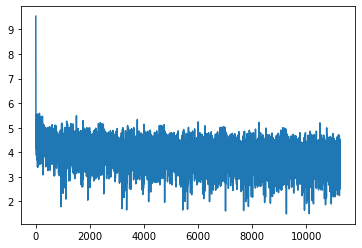

In [49]:
plt.plot(range(len(losses)), losses)
plt.show()

In [50]:
predictions, actuals = validate(0, tokenizer, model, dl_val)
results = pd.DataFrame({'Generated Text' : predictions, 'Actual Text' : actuals})

In [51]:
display(results)

,Generated Text,Actual Text
0,"I am not alone, but a violent voice John Garel...","I leaned against the mantel, sick, sick, Think..."
1,Is it a tree that is not the solemn oak? The w...,Where Claribel low-lieth The breezes pause and...
2,Iâm a creature Whose claw is the body of an an...,When the eye When the edgeless screen receivin...
3,"Iâm a single segment behind the world, two wan...","Two wandering across the porcelain Siberia, on..."
4,"I would propose a red unruly seat, and then th...",(1) Nothing that exists can be temporal; still...


In [54]:
print(results.iloc[2]["Generated Text"], "\n")
print(results.iloc[2]["Actual Text"])

Iâm a creature Whose claw is the body of an animal, And in his mouth it was not. He had to be fed Bendetto da Foiano less than one or two successive popels recognized Life protected by God and all its own laws; But now there are no other things: Then we can see him as well As you know that this life has been made Of what they have done To do with their lives? A man who could kill himself In her face That she would never die Forever but for me Like my mother at first thought about death when your father died! His heart will rise from heaven where blood still spurtes My mind so much It must come back again With such love-feeding Eternity on earthly planet Earth'd world Were born alive through our eyes Or those words which were untruther Than any human being There should always be some kindled thing About how far away She knows why So many times before Her birth Was given up against them All these days 

When the eye When the edgeless screen receiving light from the edgeless universe When

## Dummy cells added by the script
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```